# DNN Prototype

Exprimenting with 1 layer NN with 340 neruons. Came up with this number since we want to keep number of neurons to be around 2/3 of input features

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from util import dict_util as du
from util import file_util as fu
from util import plot_util as pu
import pickle
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import os

Using TensorFlow backend.


In [2]:
DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
DATA_DIR = "dataset/feature_files"
DATA_FILE = "review_body-word2vec5-111909-512-nolda.csv"
MODEL_NAME = "DNN_340"
FEATURE_COLUMN = "star_rating"
directory, INBASENAME = fu.get_dir_basename(DATA_FILE)
DESCRIPTION = f"{MODEL_NAME}-nobatch-{INBASENAME}-nosmote-{FEATURE_COLUMN}"
MODEL_FILE = f"models/{DESCRIPTION}.h5"
NETWORK_HISTORY_FILE = f'models/{DESCRIPTION}-history.pkl'
REPORT_FILE = f"reports/{datetime.now().strftime(DATE_FORMAT)}-NN_notebook_protype-report.csv"

In [3]:
df = pd.read_csv(f"{DATA_DIR}/{DATA_FILE}")
rating = df[FEATURE_COLUMN]
df = df.drop(columns=["helpful_votes", "total_votes", "helpful_product", "star_rating"])

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.288502,-0.481055,0.258424,0.362731,0.475364,0.421039,0.014504,0.213545,-0.390066,0.103808,...,0.193389,-0.345230,-0.041291,0.063343,-0.230869,-0.018990,-0.462915,-0.762691,0.271782,-0.653218
1,0.173821,-0.214929,-0.098004,0.432866,0.370673,0.000804,-0.735449,0.162931,0.113988,0.468011,...,0.133606,-0.374622,-0.360892,-0.394297,-0.168498,-0.262506,-0.958892,0.099089,0.487517,-0.307144
2,-0.257559,-0.065606,0.344815,0.411276,0.090839,0.738248,0.282006,0.331116,-0.213441,0.092032,...,0.273857,-0.094201,0.245259,0.438028,-0.413395,0.425271,-0.417884,-0.886485,0.458968,-0.380352
3,-0.023537,0.186004,-0.018319,0.046002,0.285380,0.824158,0.240865,0.177934,-0.293685,0.369762,...,0.076834,0.171872,0.258420,0.169574,-0.280809,0.322120,-0.102916,-0.606135,0.186568,-0.477317
4,-0.832218,0.451893,0.474038,-0.018249,-0.478648,0.178108,-0.472869,-0.532138,-0.491469,-0.466011,...,0.594541,-0.302686,-0.511276,-0.590193,0.299716,-0.181081,-0.436865,0.996631,0.330113,-0.327735


In [5]:
rating.head()

0    5
1    5
2    5
3    5
4    3
Name: star_rating, dtype: int64

In [6]:
model = Sequential()

model.add(Dense(340, input_shape=(df.shape[1],), kernel_initializer='glorot_uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 340)               174420    
_________________________________________________________________
activation_1 (Activation)    (None, 340)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 340)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1705      
Total params: 176,125
Trainable params: 176,125
Non-trainable params: 0
_________________________________________________________________
None


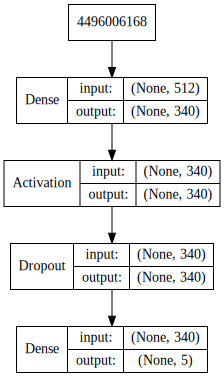

In [8]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [9]:
# one hot encode rating
print(rating.shape)
print(type(rating))
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()
y

(111909,)
<class 'pandas.core.series.Series'>


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state=1)

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
network_history = model.fit(x_train, y_train,
                      batch_size=128,
                      epochs=50,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 67144 samples, validate on 16787 samples
Epoch 1/50
67144/67144 [==============================] - 6s 89us/step - loss: 1.1210 - acc: 0.5873 - val_loss: 1.0074 - val_acc: 0.6286
Epoch 2/50
67144/67144 [==============================] - 5s 82us/step - loss: 0.9960 - acc: 0.6287 - val_loss: 0.9580 - val_acc: 0.6413
Epoch 3/50
67144/67144 [==============================] - 5s 80us/step - loss: 0.9613 - acc: 0.6365 - val_loss: 0.9344 - val_acc: 0.6472
Epoch 4/50
67144/67144 [==============================] - 5s 81us/step - loss: 0.9421 - acc: 0.6415 - val_loss: 0.9200 - val_acc: 0.6489
Epoch 5/50
67144/67144 [==============================] - 6s 85us/step - loss: 0.9287 - acc: 0.6449 - val_loss: 0.9091 - val_acc: 0.6528
Epoch 6/50
67144/67144 [==============================] - 5s 78us/step - loss: 0.9182 - acc: 0.6484 - val_loss: 0.9015 - val_acc: 0.6548
Epoch 7/50
67144/67144 [==============================] - 5s 82us/step - loss: 0

In [12]:
scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


27978/27978 [==============================] - 1s 34us/step
Accuracy: 66.78%


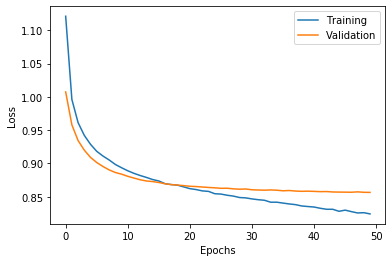

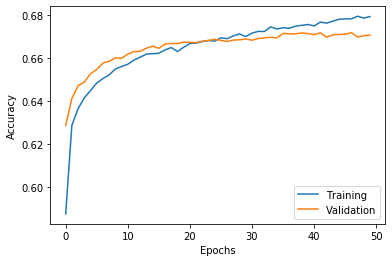

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

In [14]:
y_predict = model.predict(x_test)

In [15]:
y_predict_df = pd.DataFrame(y_predict)
y_predict_df.head()

,0,1,2,3,4
0,0.000005,0.000016,0.001577,0.067870,0.930533
1,0.106145,0.036037,0.032703,0.089543,0.735573
2,0.002314,0.002965,0.054137,0.369554,0.571030
3,0.000882,0.002734,0.020604,0.249524,0.726256
4,0.724000,0.126398,0.071267,0.029733,0.048601


In [16]:
y_predict_unencoded = [row.idxmax() + 1 for index, row in y_predict_df.iterrows()]

In [17]:
y_test_df = pd.DataFrame(y_test)
y_test_unencoded = [row.idxmax() + 1 for index, row in y_test_df.iterrows()]

In [18]:
confusion_matrix(y_test_unencoded, y_predict_unencoded)

array([[ 3063,    98,   204,   105,   405],
       [  903,    89,   286,   190,   419],
       [  502,    83,   505,   594,   876],
       [  226,    28,   247,  1045,  3091],
       [  267,    21,   149,   601, 13981]])

In [19]:
print(classification_report(y_test_unencoded, y_predict_unencoded))

              precision    recall  f1-score   support

           1       0.62      0.79      0.69      3875
           2       0.28      0.05      0.08      1887
           3       0.36      0.20      0.26      2560
           4       0.41      0.23      0.29      4637
           5       0.74      0.93      0.83     15019

    accuracy                           0.67     27978
   macro avg       0.48      0.44      0.43     27978
weighted avg       0.61      0.67      0.62     27978



# Save off various files

In [20]:
model.save(MODEL_FILE)

In [21]:
pickle.dump(network_history, open(NETWORK_HISTORY_FILE, "wb"))

In [22]:
# saving off report in the same format as other report just in case we want to compare for later
flattened = {}
flattened = du.add_dict_to_dict(flattened, classification_report(y_test_unencoded, y_predict_unencoded, output_dict=True))
flattened["confusion_matrix"] = confusion_matrix(y_test_unencoded, y_predict_unencoded)
flattened["description"] = DESCRIPTION
flattened["file"] = DATA_FILE
flattened["network_history_file"] = NETWORK_HISTORY_FILE
flattened["embedding"] = "word2vec5"
flattened["model_file"] = MODEL_FILE
flattened["model_name"] = MODEL_NAME
flattened["test_examples"] = x_test.shape[0]
flattened["test_features"] = x_test.shape[1]
flattened["train_examples"] = x_train.shape[0]
flattened["train_features"] = x_train.shape[1]
flattened["normalization"] = "na"
flattened["status"] = "success"
flattened["status_date"] = datetime.now().strftime(TIME_FORMAT)


In [23]:
# check to see if report file exisits, if so load it and append
exists = os.path.isfile(REPORT_FILE)
if exists:
    report_df = pd.read_csv(REPORT_FILE)
else:
    report_df = pd.DataFrame()
    
report_df = report_df.append(flattened, ignore_index=True)
report_df.head()



,Unnamed: 0,Unnamed: 0.1,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,...,status_date,test_examples,test_features,tokenizer_file,train_examples,train_features,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
0,0.0,0.0,0.675135,0.609566,0.756511,1651,0.147748,0.273333,0.101235,810,...,6/23/19 4:04,12500,65,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,37500,65,0.645316,0.632393,0.668640,12500
1,1.0,1.0,0.692583,0.657311,0.731855,3968,0.227756,0.263713,0.200428,1871,...,6/23/19 4:20,28011,84,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,84032,84,0.624529,0.613148,0.656349,28011
2,2.0,2.0,0.684835,0.617518,0.768625,1651,0.126774,0.271255,0.082716,810,...,6/23/19 5:12,12500,64,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,37500,64,0.646121,0.635054,0.686400,12500
3,3.0,3.0,0.696852,0.670550,0.725302,3968,0.195760,0.288843,0.148049,1871,...,6/23/19 5:20,28011,84,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,84032,84,0.636563,0.623141,0.661097,28011
4,4.0,4.0,0.695561,0.643853,0.756300,3968,0.147661,0.266760,0.102084,1871,...,6/23/19 5:51,28011,186,2019-06-23-amazon_reviews_us_Wireless_v1_00-pr...,84032,186,0.631473,0.619707,0.663561,28011


In [24]:
report_df.to_csv(REPORT_FILE, index=False)